#### Get text and duration dataframe

In [1]:
import torch
import os
import pandas as pd
import numpy as np
from navec import Navec
from slovnet.model.emb import NavecEmbedding
from typing import Union
import seaborn as sns
import pymorphy3
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm



In [2]:
data_path = '/home/viktor/Projects/Data/MagistracyDeploma/'
test_path = data_path + 'crowd_test/'
raw_crowd_test_path = test_path + 'raw_crowd_test.tsv'
raw_crowd_test = pd.read_csv(raw_crowd_test_path ,sep='\t')
text_column_name = 'speaker_text'
duration_column_name = 'duration'
duration_text = raw_crowd_test[[text_column_name, duration_column_name]]
# duration_text.info()
duration_text = duration_text.dropna()
duration_text.head()

,speaker_text,duration
0,я слушаю,5.82
1,каким стал сбер,3.70
2,где родился шерлок холмс,4.38
3,открой в браузере ennio morricone,8.58
4,каким стал сбер,3.70


In [3]:
duration_text.shape

(77833, 2)

#### Word embeddings

In [4]:
data_folder = '/home/viktor/Projects/Data/MagistracyDeploma/TestHypotheses/'
file_name = 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
path = os.path.join(data_folder, file_name)

navec = Navec.load(path)  # ~1 sec, ~100MB RAM

words = ['навек', '<unk>', '<pad>']
ids = [navec.vocab[_] for _ in words]

emb = NavecEmbedding(navec)
vocab = navec.vocab
input = torch.tensor(ids)

emb(input).shape  # 3 x 300


/home/viktor/Projects/Univer/Deploma/.venv/lib/python3.11/site-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  torch.from_numpy(navec.pq.indexes),


torch.Size([3, 300])

In [5]:
# emb(torch.tensor(navec.vocab['яма']))
def word_to_emb(emb, vocab, word_or_words: Union[str, list[str]]) -> torch.Tensor:
    def single_word_to_emb(emb, vocab, word):
        return emb(torch.tensor(vocab[word]))
    if type(word_or_words) == list:
        result = []
        for word in word_or_words:
            try:
                word_emb = single_word_to_emb(emb, vocab, word)
            except KeyError:
                continue
            result.append(word_emb)
        return result
    else:
        return single_word_to_emb(emb, vocab, word_or_words)

example_word = 'кот'
default_embedding_size = word_to_emb(emb, vocab, example_word).shape.numel()
word_to_emb(emb, vocab, example_word)
# word_to_emb(emb, vocab, ['витя', 'ваня'])

tensor([-0.4161, -0.8234,  0.1041,  0.2171, -0.1972, -0.2072,  0.4124,  0.3353,
         0.4763, -0.1746, -0.3656,  0.6460, -0.2359, -0.4967,  0.2351,  0.0293,
         0.5579, -0.1821,  0.3460, -0.4691, -0.1072, -0.2880, -0.1078,  0.0996,
        -0.4523,  0.4564,  0.6884, -0.1146, -0.0627, -0.2884,  0.3378, -0.2925,
         0.5172,  0.8344, -0.2078, -0.0337, -0.0421,  0.2375,  0.3722,  0.1258,
         0.1039, -0.2675, -0.1411,  0.1203, -0.4903, -0.0273, -0.0957, -0.0155,
         0.3530, -0.0187, -0.2534,  0.0073, -0.1871,  0.2632,  0.0475, -0.4049,
        -0.0334, -0.0777,  0.2896,  0.1553, -0.1509, -0.3095,  0.1722, -0.1822,
        -0.0854, -0.1743,  0.2572,  0.0155,  0.3648,  0.0846,  0.1715, -0.3526,
         0.7443,  0.0164,  0.5548, -0.1972,  0.3350, -0.0060, -0.2826,  0.1762,
        -0.2713,  0.0669, -0.3925,  0.2355,  0.2635,  0.2953, -0.6040,  0.1477,
         0.0168, -0.6317,  0.0766, -0.4718, -0.2756,  0.3199, -0.2244, -0.0384,
         0.2538, -0.1047,  0.2621,  0.05

In [6]:
def bag_of_words(emb, vocab, words: list[str], embedding_size = default_embedding_size) -> torch.Tensor:
    word_embeddings = word_to_emb(emb, vocab, words)
    vector_sum = torch.zeros(embedding_size)
    # if len(word_embeddings) > 0:
    for word in word_embeddings:
        vector_sum += word
    
    return vector_sum / len(word_embeddings)

bag_of_words(emb, vocab, ['кот', 'телефон']).shape

torch.Size([300])

In [7]:
text_bags_of_words = []
for text in duration_text['speaker_text']:
    words = text.lower().split(' ')
    text_bags_of_words.append(bag_of_words(emb, vocab, words))

In [8]:
text_bags_of_words_df = pd.DataFrame(text_bags_of_words, dtype='float')
duration_text_bags_of_words_df = pd.concat((duration_text, text_bags_of_words_df), axis=1)


/home/viktor/Projects/Univer/Deploma/.venv/lib/python3.11/site-packages/pandas/core/construction.py:814: RuntimeWarning: invalid value encountered in cast
  subarr = np.array(arr, dtype=dtype, copy=copy)


In [64]:
print(duration_text_bags_of_words_df.shape)
duration_text_bags_of_words_df.head()

(77833, 302)


,speaker_text,duration,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,я слушаю,5.82,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,0.258930,...,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.019849,0.055699
1,каким стал сбер,3.70,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,0.292174,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355
2,где родился шерлок холмс,4.38,-0.199201,-0.201970,-0.107651,0.102246,0.001738,-0.182565,-0.134217,-0.035429,...,-0.142165,-0.002077,-0.073691,-0.169712,0.187998,-0.286952,0.018901,-0.215588,-0.194586,-0.000220
3,открой в браузере ennio morricone,8.58,0.136984,-0.363209,-0.340083,0.231929,-0.179154,0.081780,0.023477,0.386594,...,-0.294220,0.183978,0.257248,-0.128505,0.063109,-0.345005,0.086596,0.171087,0.158903,-0.257887
4,каким стал сбер,3.70,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,0.292174,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355


In [10]:
embedding_feature_names = np.arange(0, default_embedding_size).tolist()
duration_embeddings_names = [duration_column_name] + embedding_feature_names
duration_text_bags_of_words_df[duration_embeddings_names]


,duration,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,5.82,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,0.258930,0.117051,...,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.019849,0.055699
1,3.70,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,0.292174,-0.271988,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355
2,4.38,-0.199201,-0.201970,-0.107651,0.102246,0.001738,-0.182565,-0.134217,-0.035429,0.119740,...,-0.142165,-0.002077,-0.073691,-0.169712,0.187998,-0.286952,0.018901,-0.215588,-0.194586,-0.000220
3,8.58,0.136984,-0.363209,-0.340083,0.231929,-0.179154,0.081780,0.023477,0.386594,0.389532,...,-0.294220,0.183978,0.257248,-0.128505,0.063109,-0.345005,0.086596,0.171087,0.158903,-0.257887
4,3.70,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,0.292174,-0.271988,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77828,4.20,-0.437136,-0.264342,0.056343,0.079929,0.227206,-0.079589,0.259787,0.159116,0.147455,...,-0.057448,-0.425461,-0.008076,0.026868,-0.022649,-0.617909,-0.027230,-0.110793,-0.042576,-0.003898
77829,6.22,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,-0.164615,0.199702,...,0.071241,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588
77830,6.22,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,-0.164615,0.199702,...,0.071241,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588
77831,6.22,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,-0.164615,0.199702,...,0.071241,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588


In [11]:
embeddings_corr = duration_text_bags_of_words_df[duration_embeddings_names].corr()

In [12]:
embedding_threshold = 0.1

(embeddings_corr[duration_column_name].abs() > embedding_threshold).sum()
# embeddings_corr[duration_column_name].abs()

1

In [14]:

punctuation = set(string.punctuation)


def tokens_normalization(transformations, tokens: list[str], delete_punctuation=False) -> list[str]:
    for transformation in transformations:
        tokens = map(transformation, tokens)
    
    if delete_punctuation:
        # tokens = map(lambda x: x.translate(punct_to_none), tokens)
        tokens = filter(lambda x: x not in punctuation, tokens)
        
    return list(tokens)

morph = pymorphy3.MorphAnalyzer()
lemmatizer = lambda x: morph.parse(x)[0].normal_form
transformations = [str.lower, lemmatizer]

tokens_normalization(transformations, ['КоТики'])
tokens_normalization(transformations, [','])

tokenizer_language = 'russian'

tokenizer = lambda x: nltk.word_tokenize(x, language=tokenizer_language)

def text_to_normalized_tokens(text: str, delete_punctuation=False) -> list[str]:
    tokens = tokenizer(text)
    normalized_tokens = tokens_normalization(transformations, tokens, delete_punctuation)
    
    return normalized_tokens

text_to_normalized_tokens('Коты, баОбабы', True)

['кот', 'баобаб']

In [44]:
path = './tf-idf'
token_dict = {}


# def tokenize(text):
#     tokens = nltk.word_tokenize(text)
#     stems = []
#     for item in tokens:
#         stems.append(PorterStemmer().stem(item))
#     return stems

# for dirpath, dirs, files in os.walk(path):
#     for f in files:
#         fname = os.path.join(dirpath, f)
#         print ("fname=", fname)
#         with open(fname) as pearl:
#             text = pearl.read()
#             token_dict[f] = text.lower().translate(None, string.punctuation)

tfidf = TfidfVectorizer(tokenizer=text_to_normalized_tokens, stop_words='english')
tfs = tfidf.fit_transform(['cat dog', 'dog bug'])

str = 'milk milk milk bug bug, dog'
response = tfidf.transform([str])
print(response)

# feature_names = tfidf.get_feature_names()
# for col in response.nonzero()[1]:
#     print (feature_names[col], ' - ', response[0, col])

  (0, 2)	0.33517574332792605
  (0, 0)	0.9421556246632359


In [93]:

def texts_to_tfidf_dict(texts):
    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(tokenizer=text_to_normalized_tokens)

    # Fit and transform the text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

    # Get the feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF values for each word in the text data
    tfidf_values = tfidf_matrix.toarray()

    # Find the most important words based on their TF-IDF values
    most_important_words = {}
    for i, sentence in tqdm(enumerate(texts)):
        for word in text_to_normalized_tokens(sentence, True):
            word_index = np.where(np.array(feature_names) == word)[0]
            if len(word_index) > 0:
                word_index = word_index[0]
                tfidf_score = tfidf_values[i, word_index]
                if word in most_important_words:
                    most_important_words[word] = max(most_important_words[word], tfidf_score)
                else:
                    most_important_words[word] = tfidf_score


    return most_important_words

english_texts = [
    'This is a sample sentence.',
    'Another example a sentence for demonstration purposes.',
    'My name is Viktor',
    'A dog is not cat'
    'Sample sentences help in understanding a TF-IDF vectorization.'
]
russion_texts = [
    'Мама мыла раму.',
    'Мой дядя самых честных правил.',
    'Мой дядя мыл раму дома.',
    'Дома нельзя нарушать правила.'
]

word_to_tfidf = texts_to_tfidf_dict(russion_texts)
word_to_tfidf

['.' 'дом' 'дядя' 'мама' 'мой' 'мыло' 'нарушать' 'нельзя' 'правило' 'рама'
 'самый' 'честной']


{'мама': 0.6305035039117027,
 'мыло': 0.4970962045265468,
 'рама': 0.4970962045265468,
 'мой': 0.42882143251767496,
 'дядя': 0.42882143251767496,
 'самый': 0.4916456170427456,
 'честной': 0.4916456170427456,
 'правило': 0.42049336953280086,
 'дом': 0.42882143251767496,
 'нельзя': 0.5333425209202354,
 'нарушать': 0.5333425209202354}

In [95]:
speakers_texts = duration_text_bags_of_words_df['speaker_text'].to_list()
speaker_tfidf_dict = texts_to_tfidf_dict(speakers_texts)

/home/viktor/Projects/Univer/Deploma/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['2gis' 'a' 'abba' ... 'ёжка' 'ёлка' 'ёлочка']


In [96]:
len(speaker_tfidf_dict)

10482

In [104]:
def text_to_mean_tfidf(text, tfidf_dict=speaker_tfidf_dict, tokenizer=text_to_normalized_tokens):
    tokens = text_to_normalized_tokens(text)
    sum_tfidf = 0
    for token in tokens:
        tfidf = tfidf_dict.get(token)
        if tfidf is not None:
            sum_tfidf += tfidf
    return sum_tfidf / max(len(tokens), 1)

text_to_mean_tfidf(russion_texts[0])

0.3541184417614869

In [98]:
all_features = duration_text_bags_of_words_df
all_features.head()

,speaker_text,duration,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,я слушаю,5.82,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,0.258930,...,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.019849,0.055699
1,каким стал сбер,3.70,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,0.292174,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355
2,где родился шерлок холмс,4.38,-0.199201,-0.201970,-0.107651,0.102246,0.001738,-0.182565,-0.134217,-0.035429,...,-0.142165,-0.002077,-0.073691,-0.169712,0.187998,-0.286952,0.018901,-0.215588,-0.194586,-0.000220
3,открой в браузере ennio morricone,8.58,0.136984,-0.363209,-0.340083,0.231929,-0.179154,0.081780,0.023477,0.386594,...,-0.294220,0.183978,0.257248,-0.128505,0.063109,-0.345005,0.086596,0.171087,0.158903,-0.257887
4,каким стал сбер,3.70,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,0.292174,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355


In [106]:
all_features['mean_tfidf'] = all_features['speaker_text'].apply(lambda x: text_to_mean_tfidf(x))

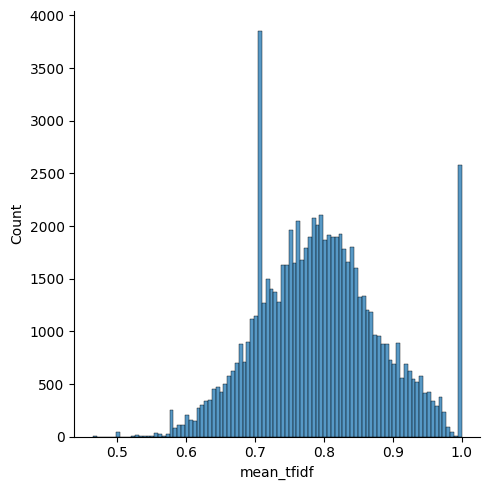

In [113]:
# penguins = sns.load_dataset("penguins")
sns.displot(all_features['mean_tfidf'].to_frame(), x="mean_tfidf")
# penguins.head()

In [105]:
# all_features.head()['speaker_text'].apply(lambda x: text_to_mean_tfidf(x))
all_features['mean_tfidf']

0    0.940797
1    0.815491
2    0.721205
3    0.705724
4    0.815491
Name: speaker_text, dtype: float64

First axis - texts, second - words 

In [114]:
all_features[['duration', 'mean_tfidf']].corr()

,duration,mean_tfidf
duration,1.000000,-0.153973
mean_tfidf,-0.153973,1.000000
